# World (IT?) Job Market Insights (Git-Girls-Collective-7)

- [ ] Section: loading data
- [ ] Section: cleaning data
- [ ] Section: transforming data
- [ ] Section: data analysis
- [ ] Section: data visualisation
- [ ] Section: data reporting

<div style="background-color: orange; padding: 10px;">
Oranges cells are missing code / comments and require information / population
<div/>

<div style="background-color: yellow; padding: 10px;">
Yellow cells are notes, to be deleted from final version
<div/>

<div style="background-color: red; padding: 10px;">
Errors, big problems that need fixing
<div/>

# Part 1 - Transforming API call Data into DataFrames (23 11 29)  
# _(A loading/cleaning/transforming section)_

### Notebook File Requirements for Part 1
The first three files our our raw datasets gathered:
* **cost_living_w_codes.csv**
* **Gender Pay Gap.csv**
* **country_codes.sql** (this must be initialised as a DB in MySQL workbench)
* **config.py** - with completed MySQL username, password and hostname
* **output_gbp_salaries_23-11-29_10-55.csv**
* 
This final file is the output of our main.py Python code, which makes several API calls to Teleport for country & salary data, and one to exchangerate-api.com for currency conversion rates. It contains the fields:  
\* country codes * local currency code * salaries in local currency (25th/50th/75th) * conversion rate to gbp * gbp converted salaries  
!! Our code is designed to give the final csv file a timestamped (so unique) name in the format output_gbp_salaries_{timestamp}, to facilitate version control and data integrity.
This is the 'frozen' snapshot of API call data upon which we based our project, timestamped 23-11-29_10-55. If you are running our Python code and Jupyter Notebook to generate a _fresh_ dataset, the csv name will be your equivilent timestamped filename.

In [ ]:
# pip install sqlalchemy # if required
# pip install openpyxl # if required

<div style="background-color: yellow; padding: 10px;">
    NB: I have tended to create a backup .csv copy of every DF created: these can be removed once happy with the code
<div/>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import math

Load the timestamped csv file which has all the combined data from our various API calls, into a pandas DataFrame

In [ ]:
api_sal_df = pd.read_csv("output_gbp_salaries_23-11-29_10-55.csv") # match the filename to the timestamped csv you are processing
api_sal_df.isnull().sum()

# Correct the missing iso_alpha2. 
null_iso_alpha2 = api_sal_df[api_sal_df['iso_alpha2'].isnull()].copy()
null_iso_alpha2 # It's Namibia, index 6552-6603
api_sal_df.loc[6552:6603, 'iso_alpha2',] = 'NA'
api_sal_df.isnull().sum() # fixed.  

### Import data from country_codes.sql, and merge with the API DataFrame   
api_sal_df at this point identifies countries only by iso_alpha2 codes, not their names, and we also want to import area and population data from country_codes.sql file.  
The following code imports data from the MySQL table and converts it into a pandas DF called "countries_df"

!! You will need to have run country_codes.sql in MySQL to have created the "database countries_db" and the "table country_codes"
!! You must also supply your MySQL login credentials below.

In [ ]:
# mysql.connector or pymysql don't work with Jupyter / MySQl

In [ ]:
# country_codes.sql information is in an .sql table. Need to convert sql > db in order for pandas to turn into into DF. Then convert to csv
from sqlalchemy import create_engine
# Import configuration variables from config.py
from config import DATABASE_USER, DATABASE_PASSWORD, DATABASE_HOST

# MySQl database connection details
username = DATABASE_USER
password = DATABASE_PASSWORD
host = DATABASE_HOST
database = 'countries_db'

# Creates a database engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}")

# The SQL query to get all info from table named country_codes
query = "SELECT * FROM country_codes"  

# Use Pandas to load data into a DataFrame
countries_df = pd.read_sql_query(query, engine)

In [ ]:
countries_df.head() # preview the imported DF

In [ ]:
# countries_df.to_csv("country_codes.csv", encoding='utf-8', index=False) # intermediate backup of DF to .csv file

Join api_sal_df to countries_df. This is an inner join because we don't need info about countries for which we have no salary data (that being the focus of our data analysis)

In [ ]:
# Inner join api_sal_df to country_codes df on iso_alpha2. The inner join excludes any countries from country_codes.sql for which we don't have salary data
biggie_dfv1 = pd.merge(api_sal_df, countries_df, on='iso_alpha2', how='inner')
# biggie_dfv1.to_csv("sal_and_country.csv", index=False) # intermediate backup of DF to .csv file

In [ ]:
biggie_dfv1.head() # preview the merged DF. [10244 rows x 19 columns]

### Join gender pay data (column) with our growing DF. Read to DF, clean, merge.

In [ ]:
# Read the data in gender_pay_parity.csv column into a new DataFrame
gender_df = pd.read_csv("Gender Pay Gap.csv")
gender_df.head(7)

In [ ]:
# Cleaning: rename coumns Country to country / Gender_Pay_Parity gender_pay_parity to facilitate merge
gender_df.rename(columns={'Country': 'country', 'Gender_Pay_Parity':'gender_pay_parity'}, inplace=True)
gender_df.head(7)

### Joining our growing DF with gender_pay_parity column data  
This is an _outer_ join because we are joining on the 'country'(name) column rather than a controlled, standardised column like iso_alpha2. If this wasn't an outer join, we may miss data which doesn't match due to minute different spellings of names. This means the data needs to be reviewed later for duplicate countries (same country but slightly different names/different characters)

In [ ]:
biggie_dfv2 = pd.merge(biggie_dfv1, gender_df, on='country', how='outer') 
# biggie_dfv2.to_csv("sal_and_country_and_gender.csv", index=False) # intermediate backup of DF to .csv file
biggie_dfv2.head(10) 
biggie_dfv2.isnull().sum()

In [ ]:
unique_countries = biggie_dfv2['country'].unique().tolist()
count_countries = len(unique_countries)
count_countries # 216

### Final join for our growing DF with columns from cost_of_living data (from WorldData)

In [ ]:
# Again, load the cost_of_living.csv data into a DF
cost_living_df = pd.read_csv("cost_living_w_codes.csv")
cost_living_df.head(7)

In [ ]:
# Then merge cost of living DF with our current main DF, to create a final superlarge DF containing all data
biggie_dfv3 = pd.merge(biggie_dfv2, cost_living_df, on="iso_alpha2", how="left")
biggie_dfv3.head(10)
biggie_dfv3.isnull().sum()

### Cleaning: rename the column 'rank' from cost_of_living.csv to WD_cost_living_rank for clarity

In [ ]:
biggie_dfv3.rename(columns={'rank': 'WD_cost_living_rank', 'country_or_region': 'WD_country_or_region'}, inplace=True)
biggie_dfv3.head(10)

### Cleaning: rename local currency columns (from Teleport API) to make name shorter and clearer that values are in local currency

In [ ]:
biggie_dfv3.rename(columns={'salary_percentiles_percentile_25': 'salary_local_25th_pcl', 'salary_percentiles_percentile_50': 'salary_local_50th_pcl', 'salary_percentiles_percentile_75': 'salary_local_75th_pcl', 'monthly_income_USD' : 'WD_monthly_income_USD', 'notes_special_regions' : 'WD_notes_special_regions'}, inplace=True)
# biggie_dfv3.to_csv("sal_country_gender_costliving.csv", index=False) # intermediate backup of DF to .csv file
biggie_dfv3.head(10)

In [ ]:
# add new column for GBP monthly income
def usd_monthly_income_to_GBP(USD_monthly_income):
    if isinstance(USD_monthly_income, str) and USD_monthly_income.strip():
        USD_num_only = USD_monthly_income.replace(",", "").replace(" USD","").strip()
    else:
        return None # if not a string. note, no print message, should just skip
    
    try: 
        USD_num_only = float(USD_num_only)
    except ValueError:
        print("Error converting string to int") 
        return None
    GBP_monthly_income = int(USD_num_only * 1.267997)
    return GBP_monthly_income

# Test the function with different inputs
print(usd_monthly_income_to_GBP("5000 USD"))  # Valid string input
print(usd_monthly_income_to_GBP(""))         # Empty string
print(usd_monthly_income_to_GBP("invalid"))  # Non-numeric string
print(usd_monthly_income_to_GBP(None))       # None
print(usd_monthly_income_to_GBP(0))          # Zero as a number

In [ ]:
# create df with country average monthly salary (WorldData) converted to GBP in new column 
final_df = biggie_dfv3.copy()
final_df['WD_monthly_income_GBP'] = final_df['WD_monthly_income_USD'].apply(usd_monthly_income_to_GBP)
# reordering the columns for the final DF
final_df = final_df[
    [
        'iso_alpha2',
        'country',
        'currency_code',
        'local_to_gbp_rates',
        'job_id',
        'job_title',
        'salary_local_25th_pcl',
        'gbp_converted_25th',
        'salary_local_50th_pcl',
        'gbp_converted_50th',
        'salary_local_75th_pcl',
        'gbp_converted_75th',
        'WD_country_or_region',
        'WD_cost_living_rank',
        'WD_monthly_income_USD',
        'WD_monthly_income_GBP',
        'WD_notes_special_regions',
        'cost_index',
        'purchasing_power_index',
        'gender_pay_parity',
        'iso_alpha3',
        'iso_numeric',
        'fips',
        'capital',
        'area_km2',
        'population',
        'continent'
    ]
]
final_df.to_csv("final_df_inc_GBP_monthly.csv", index=True)

# Part 2 - Making a MySQL Database
# _A loading/cleaning/transforming section_
Step 1: Splitting the large DF into 4 refined DataFrames, which were used to populate MySQL Database tables. Only run this cell if you want individual copies of the csvs.

In [ ]:
# # Create reduced DFs to serve as sql table starters
# countries_sql_table_df = final_df[['iso_alpha2', 'country', 'capital', 'continent', 'area_km2', 'population','gender_pay_parity']].drop_duplicates(subset='iso_alpha2').copy() # excluded 'iso_alpha3', 'iso_numeric' 'fips' 
# countries_sql_table_df.to_csv("countries_data_from_final_df.csv", index=False)

# cost_of_living_sql_table_df = final_df[['iso_alpha2', 'WD_country_or_region','WD_notes_special_regions','WD_cost_living_rank', 'WD_monthly_income_USD', 'WD_monthly_income_GBP', 'cost_index', 'purchasing_power_index']].drop_duplicates(subset='iso_alpha2').copy()
# cost_of_living_sql_table_df.to_csv("cost_of_living_data_from_final_df.csv", index=False)

# salaries_sql_table_df = final_df[['iso_alpha2',  'job_id', 'job_title', 'salary_local_25th_pcl', 'salary_local_50th_pcl', 'salary_local_75th_pcl', 'currency_code', 'local_to_gbp_rates','gbp_converted_25th','gbp_converted_50th', 'gbp_converted_75th']].copy()
# salaries_sql_table_df.to_csv("salaries_data_from_final_df.csv", index=False)

# job_sql_table_df = final_df[['job_id', 'job_title']].drop_duplicates(subset='job_id').copy()
# job_sql_table_df.to_csv("job_data_from_final_df.csv", index=False)

<div style="background-color: yellow; padding: 10px;">
    Cost of living data from WorldData hasn't made it's way into the SQL database. If we don't end up using it at all, we need to go back through Part 1 and remove the steps, references and comments related to this dataset.
<div/>

<div style="background-color: orange; padding: 10px;">
    <ul>
        <li>Need commentary here about the steps taken the SQL Database was constructed </li> 
        <li>Need code (or a reference to an external file, if it is too long to put into the Jupyter NB) which will allow instructor to construct SQL Database/</li>  
        <li>The SQL tables contain the 4 fixes NP identified (Namibia, and three outdated currency codes). We went back and fixed these errors at source in the Python code, so fresh datasets won't have these problems, however we had already frozen the versions of our data used when it was imported into the SQL database. This means that we need to provide some code that can be run on the datasets we used, to fix the problems.</li>
        <li>The code below also starts it's analysis from Job Insights.xlsx. We need to provide code or an explanation as to how we got this file from the SQL database.</li>
        <li>How were the gbp converted salaries calculated for VES, MRU, BYN? The gbp salaries were blank in the original DFs, as there wasn't a match between Teleport and the currency API. Was it manually done from plugging in the the currency conversion rates from the json? </li>
    </ul>
<div/>

<div style="background-color: orange; padding: 10px;">
During the SQL Database creation, 3 currency code mismatches were uncovered, as was a problematic iso_alpha2 country code (Namibia, NA).
Insert relevant screenshots from NP presentation here! & explanation
<div/>

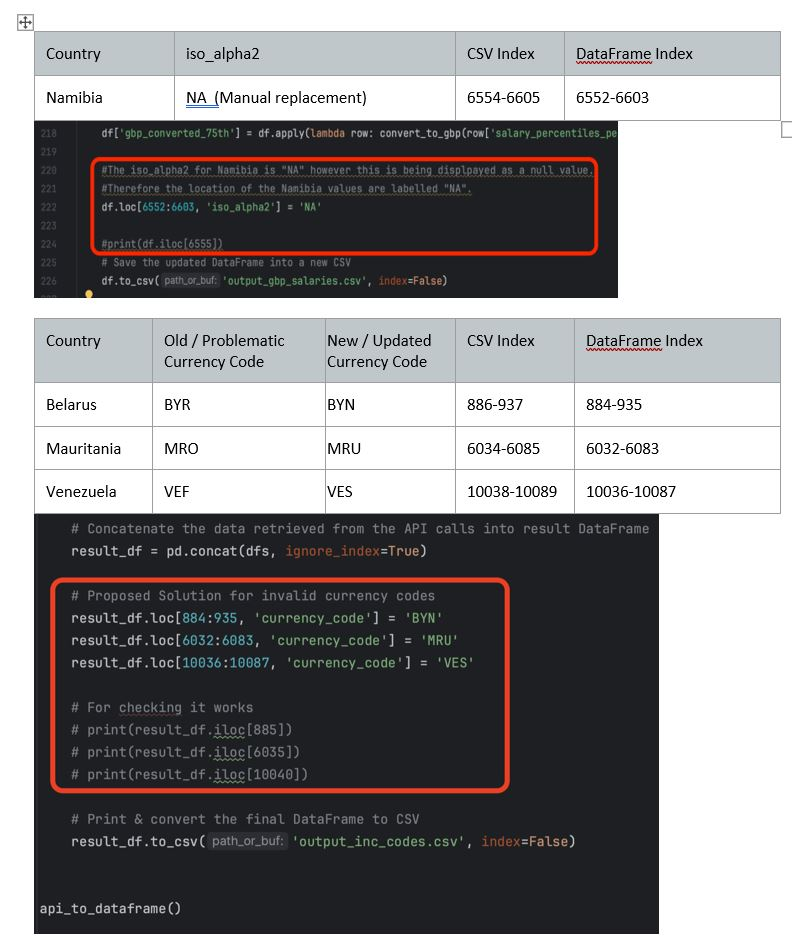

# Part 3 - Loading data from (xlxs file exported from) MySQL tables into DataFrames for analysis. _(A loading/cleaning/transforming section)_

<div style="background-color: yellow; padding: 10px;">
This section of code requires the file 'Job Insights.xlsx' to be in the directory. Or we need to supply some code above which generates this xlsx file from the SQL database.
<div/>

### Notebook File Requirements for Part 3
* **Job Insights.xlsx**

In [ ]:
# Countries table only
SQL_countries_df = pd.read_excel('Job Insights.xlsx', sheet_name = 'Countries')
SQL_countries_df.isnull().sum()

In [ ]:
# Correct the missing iso_alpha2. This was a PK in the SQL DB, so must have been present but lost in conversion to DF
null_iso_alpha2 = SQL_countries_df[SQL_countries_df['iso_alpha2'].isnull()]
null_iso_alpha2 # It's Namibia, index 159
SQL_countries_df.loc[159, 'iso_alpha2'] = 'NA'
SQL_countries_df.isnull().sum() # fixed.  

In [ ]:
null_currency_code = SQL_countries_df[SQL_countries_df['currency_code'].isnull()]
null_currency_code  # It's Antarctica, index 8
# Replace DF with DF keeping only the rows where iso_alpha2 is not 'AQ'
SQL_countries_df = SQL_countries_df[SQL_countries_df['iso_alpha2'] != 'AQ']
SQL_countries_df.isnull().sum()  # fixed. So 113 countries with no gender_Pay info, and 41 without a continent

In [ ]:
# Salaries table only
SQL_salaries_df = pd.read_excel('Job Insights.xlsx', sheet_name = 'Salaries')
SQL_salaries_df.isnull().sum() # Namibia causing problems again! 

In [ ]:
# Convert Namibia's "NA" iso_alpha2 code from NaN values (lost in DF creation) to the country code NA
SQL_salaries_df.loc[6553:6604, 'iso_alpha2'] = 'NA'
SQL_salaries_df.iloc[6553:6604]
SQL_salaries_df.isnull().sum() # all 0, so all columns complete

In [ ]:
SQL_all_df = pd.merge(SQL_salaries_df, SQL_countries_df, on='iso_alpha2', how='inner')
SQL_all_df.to_excel("SQL_all_data_joined_inner.xlsx", index=True)
SQL_all_df.isnull().sum()

# Part X - Basic Analysis _(an Analysis Section)_

In [ ]:
# Basic analysis
countries_list = SQL_all_df['iso_alpha2'].unique().tolist() 
countries_count = len(countries_list) # 198 unique country codes
countries_count

In [ ]:
jobs_list = SQL_all_df['Job_id'].unique().tolist() 
jobs_count = len(jobs_list) #  52 unique jobs
jobs_count

# Part X - Heatmap _(an Analysis Section)_

In [ ]:
# Heatmap of the null values
plt.figure(figsize = (8,6))
ax = sns.heatmap(SQL_all_df.isnull(), cmap = 'viridis', cbar=False, annot=False)

# Absolute totals of missing values for annotations for columns
tot_gender_pay_missing = SQL_all_df['gender_Pay'].isnull().sum()
tot_continent_missing = SQL_all_df['continent'].isnull().sum()

# Positioning the absolute total labels
n = list(SQL_all_df.columns).index('gender_Pay')
m = list(SQL_all_df.columns).index('continent')
ax.text(n+0.5, -0.5, tot_gender_pay_missing, ha='center', va='bottom', color='green', fontsize=15) 
ax.text(m+0.5, -0.5, tot_continent_missing, ha='center', va='bottom', color='green', fontsize=15) 

# legend
plt.text(0.02, 0.75, 'Green Text = Total Missing Values', color='green', fontsize=15, transform=ax.transAxes)

ax.set_title('Missing Data Heatmap', pad=20, fontsize=15)
plt.ylabel('Entries Missing')
plt.xlabel('Data Feature')
plt.show()

In [ ]:
missing_gender_pay = int(tot_gender_pay_missing / jobs_count)
missing_gender_pay # 69
print(f"There are {missing_gender_pay} countries without gender pay parity figures out of {countries_count}, which is {(missing_gender_pay/countries_count)*100:.2f}%")

## **Analysis**
* Due to our data processing choices and the nature of our joins, our data is fully saturated for the series we are most interested in (country, salaries in GBP).
* Missing continent data could be fairly easily updated, however given the time alloted for our analysis we are unlikely to be able to branch out into broadeer factors like geography, continent etc.
* We do not have full gender pay parity figures for all countries, only 66% of our total dataset. However, that does still leave 129 countries with complete data, which means it is likely to be worth analysing. 

# Part X - Analysis of Extreme Values _(an Analysis Section)_

To be continued... 

# Part X - Adaptation of Questions to Extreme Values _(an Analysis Section)_

#To convert the NaN values to the country code NA
data=pd.read_csv('salaries.csv')
data.loc[6553:6604, 'iso_alpha2'] = 'NA'
data.iloc[6553:6604]

In [ ]:
data.isnull().sum()

In [ ]:
#This was where I realised the GBP values were wildly different
X = np.where(data['Job_id'] == 'DATA-ANALYST')
df = data.iloc[X]
df

In [ ]:
sns.boxplot(df['percentile_50_GBP'])

In [ ]:
sns.histplot(df["percentile_50_GBP"], kde=True, stat="frequency")

In [ ]:
def analyst():
    iso_alpha2 = data['iso_alpha2'].unique()
    more=[]
    less=[]
    equal=[]
    
    for x in range(len(iso_alpha2)):
        it = np.where(data['iso_alpha2'] == iso_alpha2[x])
        it = it[0]
        df = data.iloc[it]
        
        med = df['percentile_50_GBP'].median()
        r_med = math.ceil(med*100)/100
        #print(r_med)
        data_analyst = df.iloc[np.where(df['Job_id'] == 'DATA-ANALYST')]
        salary = data_analyst['percentile_50_GBP']
        r_salary = math.ceil(salary.item()*100)/100 
        #print(r_salary)
        
        if r_salary < r_med:
            print(data_analyst['iso_alpha2'].item())
            print('less than median\n')
            more.append(salary.item)

        elif r_salary > r_med:
            print(data_analyst['iso_alpha2'].item())
            print('more than median\n')
            less.append(salary.item)

        elif r_salary == r_med:
            print(data_analyst['iso_alpha2'].item())
            print('same as median\n')
            equal.append(salary.item)

        else:
            print(data_analyst['iso_alpha2'].item())
            print('error')

    return(len(more), len(equal), len(less))
    

In [ ]:
analyst()

In [ ]:
bar_width = 0.2
between_bars = 0.2
fig, ax = plt.subplots()

ax.bar( 'Less than Median', 164, color='blue', label='Less than Median') 
ax.bar('More than Median', 34,  color='orange', label='More than Median')

ax.set_ylabel('Number of Countries')
ax.set_title('Number of Countries where Data Analysts are payed Less and More than Median')

ax.legend()
plt.show()

In [ ]:
def s_engineer():
    data.dropna(inplace=True)
    iso_alpha2 = data['iso_alpha2'].unique()
    more=[]
    less=[]
    equal=[]
    
    for x in range(len(iso_alpha2)):
        it = np.where(data['iso_alpha2'] == iso_alpha2[x])
        it = it[0]
        df = data.iloc[it]
        
        med = df['percentile_50_GBP'].median()
        r_med = math.ceil(med*100)/100
        #print(r_med)
        data_analyst = df.iloc[np.where(df['Job_id'] == 'SOFTWARE-ENGINEER')]
        salary = data_analyst['percentile_50_GBP']
        r_salary = math.ceil(salary.item()*100)/100 
        #print(r_salary)
        
        
        if r_salary < r_med:
            print(data_analyst['iso_alpha2'].item())
            print('less than median\n')
            more.append(salary.item)

        elif r_salary > r_med:
            print(data_analyst['iso_alpha2'].item())
            print('more than median\n')
            less.append(salary.item)

        elif r_salary == r_med:
            print(data_analyst['iso_alpha2'].item())
            print('same as median\n')
            equal.append(salary.item)

        else:
            print(data_analyst['iso_alpha2'].item())
            print('error')

    return(len(more), len(equal), len(less))

In [ ]:
s_engineer()

In [ ]:
x_values = ['Data Analyst', 'Software Engineer']
data1 = [173, 16]
data2 = [30, 182]

bar_width = 0.25

positions1 = np.arange(len(x_values))
positions2 = positions1 + bar_width

fig, ax = plt.subplots()

ax.bar(positions1, data1, width=bar_width, label='Less than Median')
ax.bar(positions2, data2, width=bar_width, label='More than Median')


# Set labels and title
ax.set_xticks(positions1 + bar_width)
ax.set_xticklabels(x_values)
ax.set_ylabel('Number of Countries')
ax.set_title('Number of Countries where IT roles pay Less and More than the Median')

# Show legend
ax.legend(loc='upper left')


plt.show()

<div style="background-color: red; padding: 10px;">
# CELLS BEYOND THIS POINT NOT RUN, just notes / ideas!
<div/>

### List of IT Jobs

In [ ]:
# IT jobs (Job_id) column
it_roles = ['BUSINESS-ANALYST', 'DATA-ANALYST', 'DATA-SCIENTIST', 'IT-MANAGER', 'MOBILE-DEVELOPER', 'PRODUCT-MANAGER', 'QA-ENGINEER', 'SOFTWARE-ENGINEER', 'UX-DESIGNER', 'WEB-DESIGNER', 'WEB-DEVELOPER']

### Cleaning task: Need to clean these names, if they are still in the dataset

In [ ]:
CuraÃ§ao	Willemstad
Ã…land	Mariehamn
Saint BarthÃ©lemy	Gustavia
RÃ©union	Saint-Denis
SÃ£o TomÃ© and PrÃ­ncipe

# Define the dodgy characters to search for
dodgy_character = 'Ã' AND .... 

# Create a boolean mask to identify rows with the dodgy character in any field
mask = df.apply(lambda x: x.str.contains(dodgy_character)).any(axis=1)

# Get the rows with the dodgy character
dodgy_rows = df[mask]

# Print or process the dodgy rows
print(dodgy_rows)
